In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,random_split,Subset
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix
import seaborn as sns

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [3]:
dataset = datasets.ImageFolder('/kaggle/input/microsoft-catsvsdogs-dataset/PetImages', transform=transform)

In [4]:
images_ind = []
IGNORE_PATHS = [
    '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/11702.jpg',
    '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat/666.jpg'
]

for idx, (img_path, label) in enumerate(dataset.samples):
    if img_path not in IGNORE_PATHS:
        images_ind.append(idx)
        
new_dataset = Subset(dataset, indices=images_ind)

In [5]:
train_ratio = 0.7
test_ratio = 0.15
validation_ratio = 0.15
# Calculate the number of samples for each split
num_samples = len(new_dataset)
num_train = int(train_ratio * num_samples)
num_test = int(test_ratio * num_samples)
num_val = num_samples - num_train - num_test

# Use random_split to split the filtered dataset
train_data, test_validation_data = random_split(new_dataset, [num_train, num_test + num_val])
test_data, validation_data = random_split(test_validation_data, [num_test, num_val])

In [6]:
#Data loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
validation_loader = DataLoader(validation_data, batch_size=32, shuffle=False)

In [7]:
# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 56 * 56, 64)
        self.relu3 = nn.ReLU() 
        self.fc2 = nn.Linear(64, 128)
        self.relu4 = nn.ReLU() 
        self.fc3 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu3(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
model = SimpleCNN().to(device)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001,weight_decay=0.0001)

In [9]:
num_epochs = 10
loss_graph = []
loss_valid = []
accuracy_graph = []
accuracy_valid = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    # Print training loss and accuracy
    epoch_loss = running_loss / len(train_loader)
    accuracy_train = correct_train / total_train * 100
    loss_graph.append(epoch_loss)
    accuracy_graph.append(accuracy_train)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy_train:.2f}%')
    # Validation loop
    model.eval()
    correct_val = 0
    total_val = 0
    test_loss = 0
    valid_loss = 0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    accuracy_val = correct_val / total_val * 100
    valid_loss = valid_loss / len(validation_loader)
    accuracy_valid.append(accuracy_val)
    loss_valid.append(valid_loss)
    print(f'validation Accuracy: {accuracy_val:.2f}% , validation loss : {valid_loss:.4f}')

/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 1/10, Loss: 0.6928, Accuracy: 51.14%
validation Accuracy: 49.83% , validation loss : 0.6927
Epoch 2/10, Loss: 0.6923, Accuracy: 51.12%
validation Accuracy: 52.87% , validation loss : 0.6923
Epoch 3/10, Loss: 0.6919, Accuracy: 52.09%
validation Accuracy: 53.99% , validation loss : 0.6919
Epoch 4/10, Loss: 0.6914, Accuracy: 54.63%
validation Accuracy: 52.49% , validation loss : 0.6915
Epoch 5/10, Loss: 0.6909, Accuracy: 54.51%
validation Accuracy: 53.08% , validation loss : 0.6910
Epoch 6/10, Loss: 0.6904, Accuracy: 55.03%
validation Accuracy: 54.68% , validation loss : 0.6904
Epoch 7/10, Loss: 0.6899, Accuracy: 55.23%
validation Accuracy: 56.46% , validation loss : 0.6898
Epoch 8/10, Loss: 0.6894, Accuracy: 56.67%
validation Accuracy: 56.84% , validation loss : 0.6893
Epoch 9/10, Loss: 0.6890, Accuracy: 56.89%
validation Accuracy: 56.41% , validation loss : 0.6889
Epoch 10/10, Loss: 0.6885, Accuracy: 57.36%
validation Accuracy: 56.33% , validation loss : 0.6884


In [14]:
import matplotlib.pyplot as plt

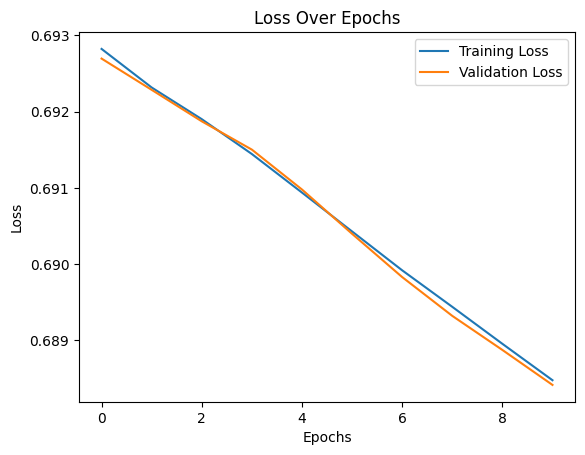

In [15]:
plt.plot(loss_graph, label='Training Loss')
plt.plot(loss_valid, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

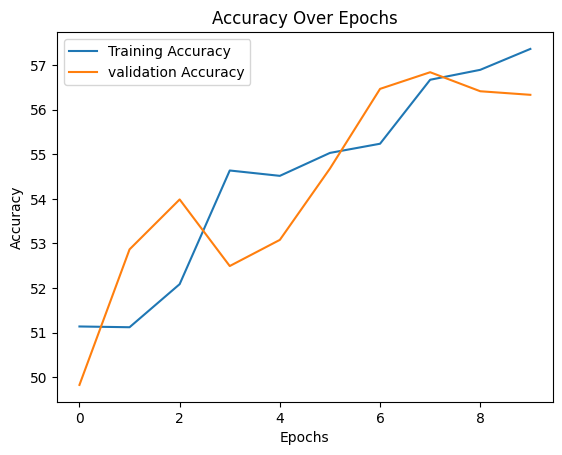

In [16]:
plt.plot(accuracy_graph, label='Training Accuracy')
plt.plot(accuracy_valid, label='validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()

Final Test Accuracy: 56.50%


Text(0.5, 1.0, 'Confusion Matrix')

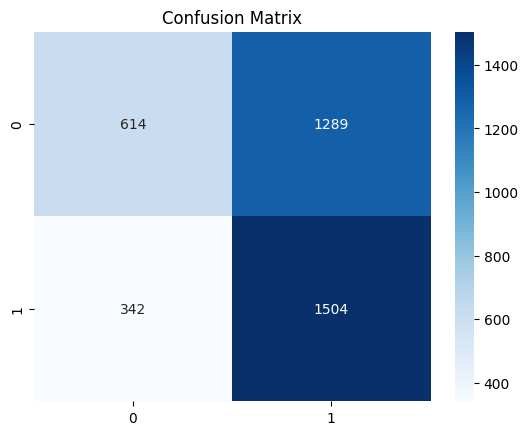

In [17]:
# Final evaluation on the test set
model.eval()
correct_top_test = 0
total_test = 0
all_labels = []
all_predictions_top = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        _, predicted_top = torch.max(outputs.data, 1)
        correct_top_test += (predicted_top == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_predictions_top.extend(predicted_top.cpu().numpy())

        total_test += labels.size(0)

accuracy_test = correct_top_test / total_test * 100

print(f'Final Test Accuracy: {accuracy_test:.2f}%')

conf_matrix_top = confusion_matrix(all_labels, all_predictions_top)
sns.heatmap(conf_matrix_top, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")